In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

# Download NLP resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [156]:
def remove_noise(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^\x00-\x7F\u0600-\u06FF]+', ' ', text)  # keep numbers
    return text

def normalization(text):
    return text.lower()

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def tokenize(text):
    return word_tokenize(text)

def stop_word_removal(tokens):
    stop_words = set(stopwords.words('english'))
    return [t for t in tokens if t not in stop_words]

def lemmatizing(tokens):
    le = WordNetLemmatizer()
    return [le.lemmatize(t) for t in tokens]

def txt_prep(text):
    text = remove_noise(text)
    text = normalization(text)
    text = remove_punctuation(text)
    tokens = tokenize(text)
    tokens = stop_word_removal(tokens)
    tokens = lemmatizing(tokens)
    return " ".join(tokens)


In [ ]:

df_true = pd.read_csv('true.csv')
df_fake = pd.read_csv('fake.csv')

df_true["label"] = 1   # TRUE
df_fake["label"] = 0   # FAKE

df = pd.concat([df_true, df_fake], ignore_index=True)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1


In [158]:
df["cleaned_text"] = df["text"].apply(txt_prep)
df["cleaned_title"] = df["title"].apply(txt_prep)
df["cleaned_subject"] = df["subject"].apply(txt_prep)

df_cleaned = df[["cleaned_text", "cleaned_subject", "cleaned_title", "date", "label"]].copy()
df_cleaned["label_t"] = df_cleaned["label"].map({1: "true", 0: "fake"})

df_cleaned.head()


,cleaned_text,cleaned_subject,cleaned_title,date,label,label_t
0,washington reuters head conservative republica...,politicsnews,u budget fight loom republican flip fiscal script,2017-12-31,1,true
1,washington reuters transgender people allowed ...,politicsnews,u military accept transgender recruit monday p...,2017-12-29,1,true
2,washington reuters special counsel investigati...,politicsnews,senior u republican senator let mr mueller job,2017-12-31,1,true
3,washington reuters trump campaign adviser geor...,politicsnews,fbi russia probe helped australian diplomat ti...,2017-12-30,1,true
4,seattlewashington reuters president donald tru...,politicsnews,trump want postal service charge much amazon s...,2017-12-29,1,true


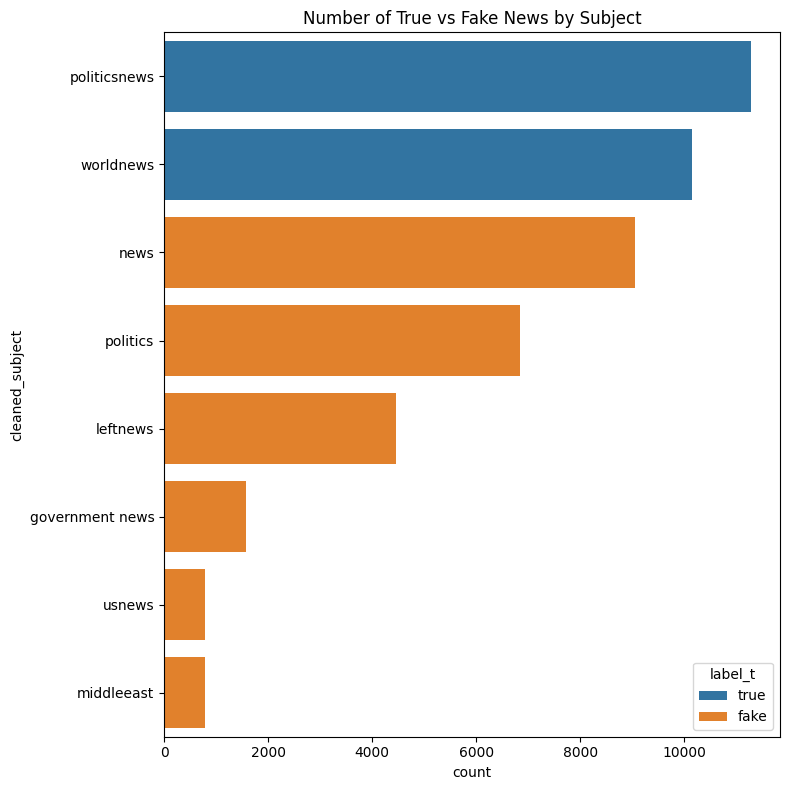

In [159]:
plt.figure(figsize=(8,8))
sns.countplot(
    data=df_cleaned,
    y="cleaned_subject",
    hue="label_t",
    order=df_cleaned["cleaned_subject"].value_counts().index
)
plt.title("Number of True vs Fake News by Subject")
plt.tight_layout()
plt.show()


In [160]:
df_cleaned["full_text"] = (
    df_cleaned["cleaned_title"] + " " +
    df_cleaned["cleaned_subject"] + " " +
    df_cleaned["cleaned_text"]
)

X = df_cleaned["full_text"]
y = df_cleaned["label"]

X.head()


,full_text
0,u budget fight loom republican flip fiscal scr...
1,u military accept transgender recruit monday p...
2,senior u republican senator let mr mueller job...
3,fbi russia probe helped australian diplomat ti...
4,trump want postal service charge much amazon s...


In [161]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [162]:
tf = TfidfVectorizer(
    max_features=50000,
    stop_words="english",
    ngram_range=(1,2)
)

X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)


In [163]:
model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)

model.fit(X_train_tf, y_train)
y_pred = model.predict(X_test_tf)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



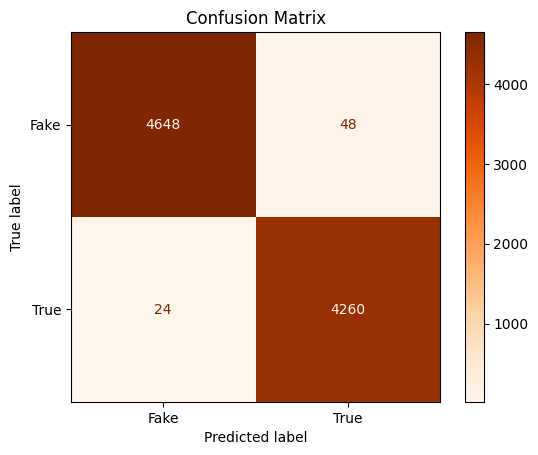

In [164]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "True"])
disp.plot(cmap="Oranges", values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
joblib.dump(model, 'my_Fake_news_detection_model.pkl')
joblib.dump(tf, 'my_vectorizer.pkl')

['my_vectorizer.pkl']